In [1]:
# Augmentation is a technique used to apply random transformation to
# the training data to simpuate more varience in the data

In [2]:
import tensorflow as tf
import random
import numpy as np
import os
from dataclasses import dataclass
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import zipfile
import requests
import glob as glob

block_plot = False
plt.rcParams['figure.figsize'] = (12, 9)

# Text formatting.
bold = "\033[1m"

# Fix seeds for reproducibility.
SEED_VALUE = 2000

random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)

In [3]:
def system_config():

    # Get list of GPUs.
    gpu_devices = tf.config.list_physical_devices('GPU')
    print(gpu_devices)

    if len(gpu_devices) > 0:
        print('Using GPU')
        os.environ["CUDA_VISIBLE_DEVICES"] = '0'
        os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

        # If there are any gpu devices, use first gpu.
        tf.config.experimental.set_visible_devices(gpu_devices[0], 'GPU')

        # Grow the memory usage as it is needed by the process.
        tf.config.experimental.set_memory_growth(gpu_devices[0], True)

        # Enable using cudNN.
        os.environ['TF_USE_CUDNN'] = "true"
    else:
        print('Using CPU')

system_config()

[]
Using CPU


In [4]:
import requests

def download_file(url, save_name):
    url = url
    file = requests.get(url)

    open(save_name, 'wb').write(file.content)

download_file('https://www.dropbox.com/s/6nrjxr2ycnpcy63/dataset_balls.zip?dl=1', 'dataset_balls.zip')

In [5]:
import zipfile

zip_file = 'dataset_balls.zip'
try:
    with zipfile.ZipFile(zip_file) as z:
        z.extractall("./")
        print("Extracted all")
except:
    print("Invalid file")

Extracted all


In [6]:
@dataclass(frozen=True)
class DatasetConfig:
    NUM_CLASSES:  int = 10
    IMG_HEIGHT:   int = 224
    IMG_WIDTH:    int = 224
    NUM_CHANNELS: int = 3
    BATCH_SIZE:   int = 32
    DATA_ROOT:    str = './dataset_balls'

data_config = DatasetConfig()

# Set data paths.
train_path = os.path.join(data_config.DATA_ROOT, "train")
valid_path = os.path.join(data_config.DATA_ROOT, "valid")

In [7]:
input_shape = (data_config.IMG_HEIGHT, data_config.IMG_WIDTH)
batch_size = data_config.BATCH_SIZE

AUTOTUNE = tf.data.AUTOTUNE

raw_train_dataset = image_dataset_from_directory(directory=train_path,
                                             image_size=input_shape,
                                             color_mode='rgb',
                                             batch_size=batch_size,
                                             seed=SEED_VALUE,
                                             label_mode='categorical',
                                            )

raw_valid_dataset = image_dataset_from_directory(directory=valid_path,
                                             image_size=input_shape,
                                             color_mode='rgb',
                                             batch_size=batch_size,
                                             seed=SEED_VALUE,
                                             label_mode='categorical',
                                            )

# You can use the object attribute (class_names) to access the class names in the dataset.
class_names = raw_train_dataset.class_names
print("\nClass names:\n",class_names)

Found 1125 files belonging to 10 classes.
Found 200 files belonging to 10 classes.

Class names:
 ['baseball', 'basketball', 'beachballs', 'billiard ball', 'bowling ball', 'brass', 'buckeyballs', 'cannon ball', 'cricket ball', 'eyeballs']


In [8]:
train_dataset = raw_train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
valid_dataset = raw_valid_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [9]:
# Print the shape of the data and the aassociated labels.
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 224, 224, 3)
labels batch shape: (32, 10)


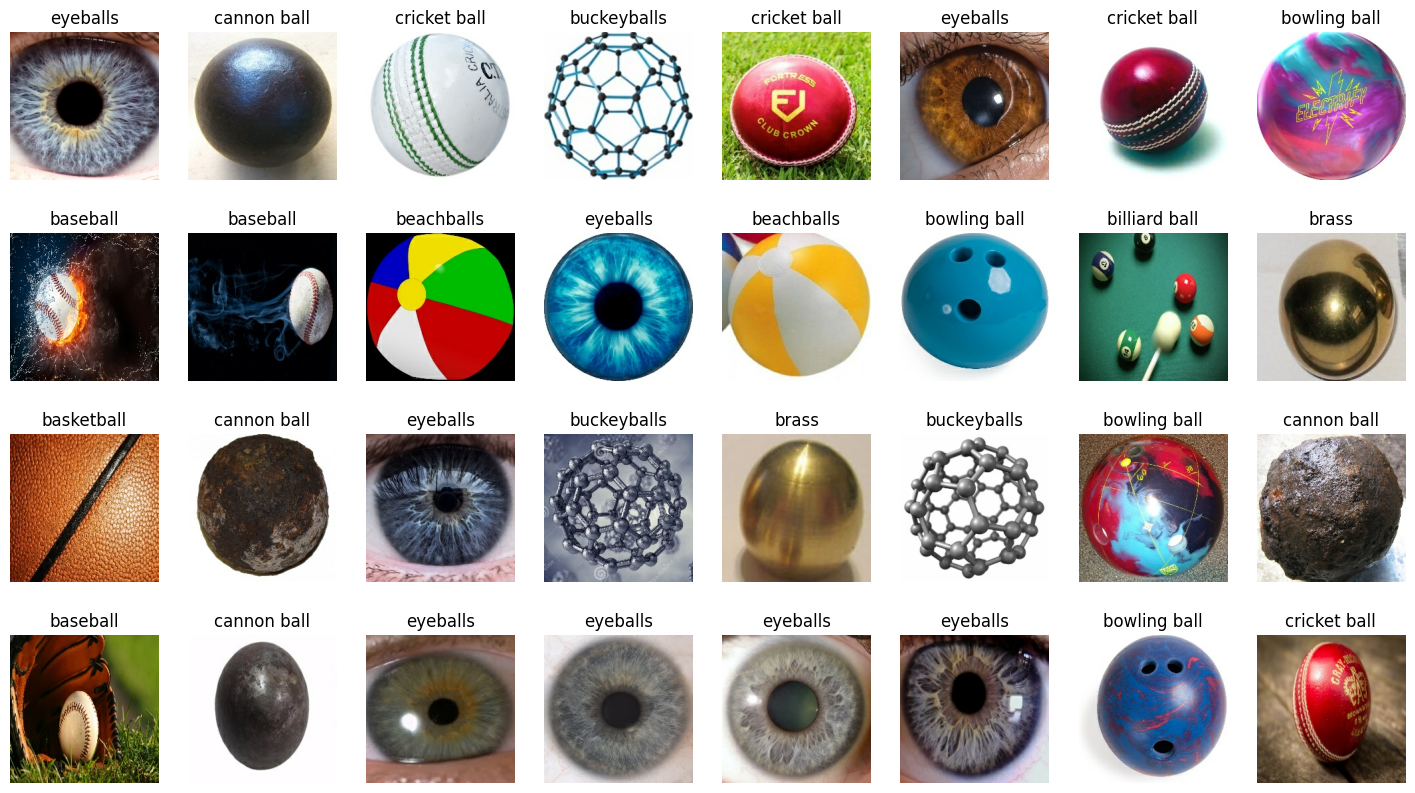

In [10]:
# Display sample images from the dataset
plt.figure(figsize=(18, 10))

# Assumes dataset batch_size is at least 32.
num_rows = 4
num_cols = 8

# Here we use the take() method to retrieve just the first batch of data from the training portion of the dataset.
for image_batch, labels_batch in train_dataset.take(1):

    # For the batch of images and the associated (one-hot encoded) labels,
    # plot each of the images in the batch and the associated ground truth labels.
    for i in range(num_rows*num_cols):
        ax = plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        truth_idx = np.nonzero(labels_batch[i].numpy())
        plt.title(class_names[truth_idx[0][0]])
        plt.axis("off")

In [11]:
# Define the model.
def cnn_model(input_shape=(224, 224, 3), num_classes=10):

    #----------------------------------------------
    # Input layer and Conv Block 1: 32-32-MaxPool.
    #----------------------------------------------
    inputs = keras.Input(shape=input_shape)

    x = layers.Rescaling(1./255)(inputs)

    x = layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.MaxPool2D(pool_size=2, strides=2)(x)

    #-----------------------------------
    # Conv Block 2: 64-64-MaxPool.
    #-----------------------------------
    x = layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.MaxPool2D(pool_size=2, strides=2)(x)

    #-----------------------------------
    # Conv Block 3: 128-128-MaxPool.
    #-----------------------------------
    x = layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.MaxPool2D(pool_size=2, strides=2)(x)

    #-----------------------------------
    # Conv Block 4: 256-256-MaxPool.
    #-----------------------------------
    x = layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.MaxPool2D(pool_size=2, strides=2)(x)

    #------------------------------------
    # Flatten the convolutional features.
    #------------------------------------
    x = layers.Flatten()(x)

    # Fully connected layers.
    x = layers.Dense(512, activation='relu')(x)

    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = keras.Model(inputs=inputs, outputs=outputs)

    return model

In [12]:
@dataclass(frozen=True)
class TrainingConfig:
    EPOCHS:             int   = 51
    LEARNING_RATE:      float = 0.001

training_config = TrainingConfig()

In [13]:
model = cnn_model(num_classes=data_config.NUM_CLASSES)

# Compile the model.
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=training_config.LEARNING_RATE),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    25,690,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,868,010 (102.49 MB)

 Trainable params: 26,868,010 (102.49 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model.
training_results = model.fit(train_dataset,
                             validation_data=valid_dataset,
                             epochs=training_config.EPOCHS,
)

Epoch 1/51
36/36 ━━━━━━━━━━━━━━━━━━━━ 539s 15s/step - accuracy: 0.1254 - loss: 2.3261 - val_accuracy: 0.1000 - val_loss: 2.3230
Epoch 2/51
36/36 ━━━━━━━━━━━━━━━━━━━━ 515s 14s/step - accuracy: 0.1623 - loss: 2.2650 - val_accuracy: 0.2050 - val_loss: 2.0992
Epoch 3/51
36/36 ━━━━━━━━━━━━━━━━━━━━ 557s 14s/step - accuracy: 0.2593 - loss: 2.0387 - val_accuracy: 0.2600 - val_loss: 1.9088
Epoch 4/51
36/36 ━━━━━━━━━━━━━━━━━━━━ 532s 15s/step - accuracy: 0.3575 - loss: 1.7897 - val_accuracy: 0.3250 - val_loss: 1.7912
Epoch 5/51
36/36 ━━━━━━━━━━━━━━━━━━━━ 511s 14s/step - accuracy: 0.4753 - loss: 1.5082 - val_accuracy: 0.3950 - val_loss: 1.6409
Epoch 6/51
36/36 ━━━━━━━━━━━━━━━━━━━━ 512s 14s/step - accuracy: 0.5616 - loss: 1.2902 - val_accuracy: 0.4900 - val_loss: 1.4823
Epoch 7/51
 7/36 ━━━━━━━━━━━━━━━━━━━━ 6:35 14s/step - accuracy: 0.6224 - loss: 0.9874

In [ ]:
# Plot training
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter)

def plot_results(metrics, title=None, ylabel=None, ylim=None, metric_name=None, color=None):

    fig, ax = plt.subplots(figsize=(15, 4))

    if not (isinstance(metric_name, list) or isinstance(metric_name, tuple)):
        metrics = [metrics,]
        metric_name = [metric_name,]

    for idx, metric in enumerate(metrics):
        ax.plot(metric, color=color[idx])

    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xlim([0, training_config.EPOCHS-1])
    plt.ylim(ylim)
    # Tailor x-axis tick marks
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    plt.grid(True)
    plt.legend(metric_name)
    plt.show(block=block_plot)
    plt.close()

In [ ]:
# Retrieve training results.
train_loss = training_results.history["loss"]
train_acc  = training_results.history["accuracy"]
valid_loss = training_results.history["val_loss"]
valid_acc  = training_results.history["val_accuracy"]

plot_results([ train_acc, valid_acc ],
            ylabel="Accuracy",
            ylim = [0.0, 1.0],
            metric_name=["Training Accuracy", "Validation Accuracy"],
            color=["g", "b"])

plot_results([ train_loss, valid_loss ],
            ylabel="Loss",
            ylim = [0.0, 5.0],
            metric_name=["Training Loss", "Validation Loss"],
            color=["g", "b"]);

In [ ]:
valid_loss, valid_acc = model.evaluate(valid_dataset)

In [ ]:
def evaluate_model(dataset, model):

    num_matches = 0
    plt.figure(figsize=(17, 12))
    num_rows = 5
    num_cols = 6

    # Retrieve a single batch.
    for data_batch, labels_batch in dataset.take(1):

        predictions = model.predict(data_batch)

        for idx in range(num_rows*num_cols):
            ax = plt.subplot(num_rows, num_cols, idx + 1)
            plt.axis("off")
            plt.imshow(data_batch[idx].numpy().astype("uint8"))

            pred_idx = tf.argmax(predictions[idx]).numpy()
            truth_idx = np.nonzero(labels_batch[idx].numpy())

            title = str(class_names[truth_idx[0][0]]) + " : " + str(class_names[pred_idx])
            title_obj = plt.title(title, fontdict={'fontsize':11})

            if pred_idx == truth_idx:
                num_matches += 1
                plt.setp(title_obj, color='g')
            else:
                plt.setp(title_obj, color='r')

            acc = num_matches/(idx+1)
        print("Prediction accuracy: ", int(100*acc)/100)

    return

In [ ]:
evaluate_model(raw_valid_dataset, model)

In [ ]:
# Data Augmentation

In [ ]:
#----------------------------------
# Define random transformations.
#----------------------------------

# Random rotation in either direction as a fraction of 2PI.
rand_rotation = layers.RandomRotation(0.15,                 # = .1*2*PI = +/- 54 deg
                                      fill_mode='nearest',  # Fill points outside boundaries with nearest pixel.
                                      seed=SEED_VALUE)

# Random horizontal flipping.
rand_flip_hor = layers.RandomFlip("horizontal", seed=SEED_VALUE)


# Random zooming.
rand_zoom     = layers.RandomZoom(height_factor=(-.5, .5),  # Zooming IN/OUT, in height up to 50%
                                  width_factor=(-.5, .5),   # Zooming IN/OUT, in width up to 50%
                                  fill_mode='nearest',      # Fill points outside boundaries with nearest pixel.
                                  seed=SEED_VALUE)

In [ ]:
def display_augmentation_rows(dataset, augmentation_pipeline, label=None):
    random.seed(SEED_VALUE)
    num_passes = 7
    plt.figure(figsize=(20, 5))

    # Retrieve a single databach.
    for image_batch, _ in dataset.take(1):

        for i in range(num_passes):

            # Pass the image_batch through the augmentation pipeline.
            augmented_images = augmentation_pipeline(image_batch)

            # Display just the first image from the batch of augmented images.
            ax = plt.subplot(1, num_passes, i + 1)
            plt.imshow(augmented_images[0].numpy().astype("uint8"))
            plt.axis("off")

        break
    print('\n')
    if label:
        print(f"{bold}", label)
    plt.show(block=block_plot)

In [ ]:
# Display augmentation samples.
display_augmentation_rows(train_dataset, rand_rotation,  'Rotation:')
display_augmentation_rows(train_dataset, rand_flip_hor,  'Horizontal Flip:')
display_augmentation_rows(train_dataset, rand_zoom,      'Zoom:')

In [ ]:
# Create Data Augmentation Pipeline

In [ ]:
# Combine multiple augmentations in a single processing pipeline using a list of transformations.
data_augmentation_pipeline = keras.Sequential(
    [
        rand_rotation,
        rand_flip_hor,
        rand_zoom,
    ]
)

In [ ]:
def display_augmentation_grid(dataset, data_augmentation_pipeline, label=None):

    random.seed(SEED_VALUE)
    num_rows = 4
    num_cols = 6
    num_passes = num_rows*num_cols
    plt.figure(figsize=(20, 13))

    # Retrieve a single databach.
    for image_batch, _ in dataset.take(1):

        for i in range(num_passes):

            # Pass the image_batch through the augmentation pipeline.
            augmented_images = data_augmentation_pipeline(image_batch)

            # Display just the first augmented image from the batch of augmented images.
            ax = plt.subplot(num_rows, num_cols, i + 1)
            plt.imshow(augmented_images[0].numpy().astype("uint8"))
            plt.axis("off")

    plt.show(block=block_plot)

In [ ]:
display_augmentation_grid(train_dataset, data_augmentation_pipeline, 'Zoom:')

In [ ]:
# Add data augmentation layer to CNN
# Define the model.
def cnn_model_aug(input_shape=(224, 224, 3), num_classes=10):

    #----------------------------------------------
    # Input layer and Conv Block 1: 32-32-MaxPool.
    #----------------------------------------------
    inputs = keras.Input(shape=input_shape)

    # Add data augmentation layer.
    x = data_augmentation_pipeline(inputs)

    x = layers.Rescaling(1./255)(x)

    x = layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.MaxPool2D(pool_size=2, strides=2)(x)

    #-----------------------------------
    # Conv Block 2: 64-64-MaxPool.
    #-----------------------------------
    x = layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.MaxPool2D(pool_size=2, strides=2)(x)

    #-----------------------------------
    # Conv Block 3: 128-128-MaxPool.
    #-----------------------------------
    x = layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.MaxPool2D(pool_size=2, strides=2)(x)

    #-----------------------------------
    # Conv Block 4: 256-256-MaxPool.
    #-----------------------------------
    x = layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.MaxPool2D(pool_size=2, strides=2)(x)

    #------------------------------------
    # Flatten the convolutional features.
    #------------------------------------
    x = layers.Flatten()(x)

    # Fully connected layers.
    x = layers.Dense(512, activation='relu')(x)

    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = keras.Model(inputs=inputs, outputs=outputs)

    return model

In [ ]:
model = cnn_model_aug(num_classes=data_config.NUM_CLASSES)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=training_config.LEARNING_RATE),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'],
              )


In [ ]:
# Train the model.
training_results = model.fit(train_dataset,
                             validation_data=valid_dataset,
                             epochs=training_config.EPOCHS,
                             )

In [ ]:
# Retrieve training results.
train_loss = training_results.history["loss"]
train_acc  = training_results.history["accuracy"]
valid_loss = training_results.history["val_loss"]
valid_acc  = training_results.history["val_accuracy"]

plot_results([ train_acc, valid_acc ],
             title="Trained Model with Data Augmentation",
             ylabel="Accuracy",
             ylim = [0.0, 1.0],
             metric_name=["Training Accuracy", "Validation Accuracy"],
             color=["g", "b"])

plot_results([ train_loss, valid_loss ],
             title="Trained Model with Data Augmentation",
             ylabel="Loss",
             ylim = [0.0, 5.0],
             metric_name=["Training Loss", "Validation Loss"],
             color=["g", "b"]);

In [ ]:
# Evaluate
valid_loss, valid_acc = model.evaluate(valid_dataset)
print(f"Validation accuracy: {valid_acc:.3f}")

In [ ]:
evaluate_model(valid_dataset, model)